In [1]:
from read_data import *

In [2]:
data_dict = process_data()

In [23]:
data_dict["V2_00001"]["dat"]

,CH1_Moment,CH2_Kraft,CH3_SyncSig,CH4_akustik,CH5_a1_WSAS,CH6_a2_WSAF,CH7_a3_BOZA,time
0,-6.3888,-663.544,11.6424,0.440715,-2.3592,10.2776,-2.49,0.00000
1,-4.5980,-937.916,11.6512,0.392493,-0.4520,13.9776,2.83,0.00005
2,-1.7908,-676.172,11.6424,0.332018,0.1752,15.2672,-3.04,0.00010
3,-3.8236,-924.140,11.6480,0.424509,2.9848,13.9440,2.14,0.00015
4,-1.5972,-994.168,11.6752,0.402375,6.0400,9.6064,3.42,0.00020
...,...,...,...,...,...,...,...,...
5290809,-1.5488,-1065.344,11.6480,0.085376,-0.2472,0.2952,-0.48,264.54045
5290810,-3.6300,-1090.600,11.6472,0.028459,-0.2952,0.1416,-0.19,264.54050
5290811,-5.9532,-1153.740,11.6464,-0.031226,-0.0224,-0.3696,-0.04,264.54055
5290812,-1.2584,-1021.720,11.6472,0.000791,0.4000,-0.1360,-1.17,264.54060


In [48]:
# take the sensor CH1_Moment and time as index into a dataframe:
df_sensor = pd.DataFrame(data_dict["V2_00001"]["dat"]["CH2_Kraft"])
df_sensor.index = data_dict["V2_00001"]["dat"]["time"]

df_sensor

,CH2_Kraft
time,
0.00000,275.904
0.00005,714.668
0.00010,486.664
0.00015,-252.912
0.00020,-956.084
...,...
291.49655,-164.776
291.49660,-465.588
291.49665,-668.684


In [31]:
from decompose_ts import *

res = decompose_ts_dataset(data_dict, "V10_0001", plot_fig=False)

In [36]:
df_trend = res['CH2_Kraft'].trend.sample(frac=0.1, random_state=42)
df_trend

time
73.40575    -9891.737236
256.26210   -1117.341885
193.47510   -9049.745734
62.90195    -9874.317369
11.72955     -766.477755
                ...     
239.12125   -9157.853496
109.25560   -9118.872439
203.44895   -9257.776536
25.47495     -706.327119
233.45070   -9155.843894
Name: trend, Length: 529081, dtype: float64

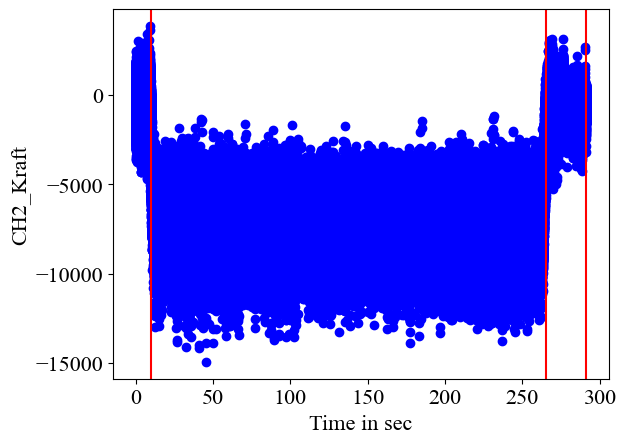

In [49]:
# Given the following change points for CH1 sensor:
change_points_v2_ch2 = [204954, 5306149, 5829935]

# Plot the change points on the time series plot:
plt.scatter(df_sensor.index, df_sensor, color='blue')
plt.axvline(x=df_sensor.index[change_points_v2_ch2[0]], color='red')
plt.axvline(x=df_sensor.index[change_points_v2_ch2[1]], color='red')
plt.axvline(x=df_sensor.index[change_points_v2_ch2[2]], color='red')

# add labels
plt.xlabel('Time in sec')
plt.ylabel('CH2_Kraft')

plt.show()

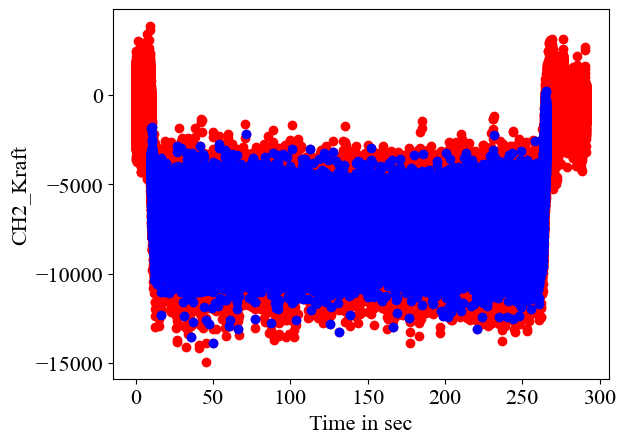

In [52]:
# Take the dataset between the second and third change points
df_sensor_sample_1 = df_sensor.iloc[change_points_v2_ch2[0]:change_points_v2_ch2[1]].sample(frac=0.1, random_state=42)

# plot the df_sensor_sample_1 data in blue color and the whole time series data in red color
plt.scatter(df_sensor.index, df_sensor, color='red')
plt.scatter(df_sensor_sample_1.index, df_sensor_sample_1, color='blue')
# add labels
plt.xlabel('Time in sec')
plt.ylabel('CH2_Kraft')
plt.show()


In [43]:
# Fit an ARIMA model to the data, there is no seasonality or trend in the data
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Split the data into train and test sets
train_size = int(df_sensor_sample_1.shape[0] * 0.7)
train, test = df_sensor_sample_1.iloc[:train_size], df_sensor_sample_1.iloc[train_size:]

# Fit an ARIMA model to the training data
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# Forecast the test data
forecast = model_fit.forecast(steps=len(test))

/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [44]:
# put the forecast values and test values side to side in a dataframe
forecast_data = pd.DataFrame(forecast.values, index=test.index, columns=['Prediction'])
forecast_data['Actual'] = test

# reorder the time index of the forecast_data dataframe
forecast_data = forecast_data.sort_index()
forecast_data

,Prediction,Actual
time,,
90.93665,-8102.120895,-10248.196
90.94035,-8102.120895,-10311.336
90.94310,-8102.120895,-8440.096
90.94320,-8102.120895,-8800.568
90.94420,-8102.120895,-10258.528
...,...,...
251.10045,-8102.120895,-2998.576
251.10065,-8102.120895,-5472.516
251.10330,-8102.120895,-8844.192


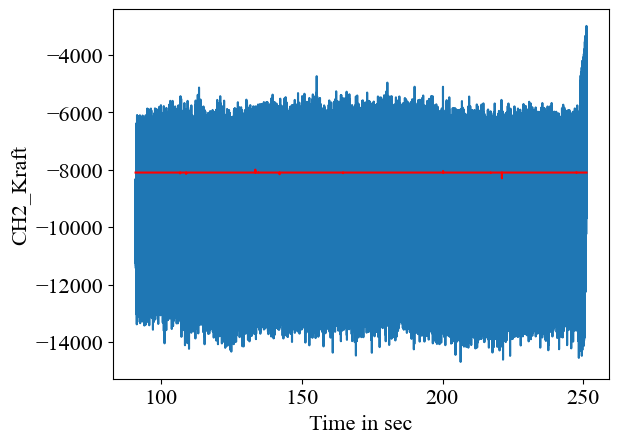

In [46]:
# plot the prediction and actual values of the forecast_data dataframe
plt.plot(forecast_data['Actual'])
plt.plot(forecast_data['Prediction'], color='red')

# add labels
plt.xlabel('Time in sec')
plt.ylabel('CH2_Kraft')

plt.show()

In [53]:
# Fit an exponential smoothing model to the data
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Split the data into train and test sets
train_size = int(df_sensor_sample_1.shape[0] * 0.7)
train, test = df_sensor_sample_1.iloc[:train_size], df_sensor_sample_1.iloc[train_size:]

# Fit an exponential smoothing model to the training data
model = ExponentialSmoothing(train)
model_fit = model.fit()

# Forecast the test data
forecast = model_fit.forecast(steps=len(test))

/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [54]:
# put the forecast values and test values side to side in a dataframe
forecast_data = pd.DataFrame(forecast.values, index=test.index, columns=['Prediction'])
forecast_data['Actual'] = test

# reorder the time index of the forecast_data dataframe
forecast_data = forecast_data.sort_index()
forecast_data

,Prediction,Actual
time,,
10.24850,-7384.757918,-3494.784
10.24980,-7384.757918,-3927.800
10.24985,-7384.757918,-4516.012
10.25180,-7384.757918,-4544.752
10.25380,-7384.757918,-3199.720
...,...,...
265.30375,-7384.757918,-2379.672
265.30430,-7384.757918,-707.004
265.30530,-7384.757918,-2029.044


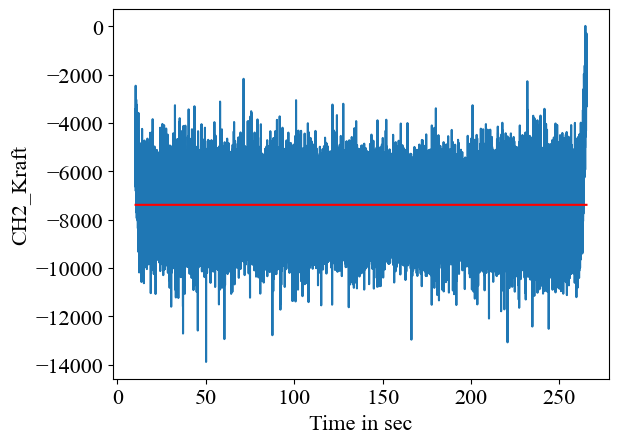

In [56]:
# plot the prediction and actual values of the forecast_data dataframe
plt.plot(forecast_data['Actual'])
plt.plot(forecast_data['Prediction'], color='red')

#add labels
plt.xlabel('Time in sec')
plt.ylabel('CH2_Kraft')
plt.show()

In [ ]:
# Use Gridsearch approach to look for the best params to fit to the SARIMAx model:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools


p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Initialize variables to store the best parameters and minimum AIC score
best_params = None
best_score = np.inf

# Loop through all parameter combinations and fit the SARIMAX model to the data
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(
                df_sensor_sample.values,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit()
            if results.aic < best_score:
                best_params = (param, param_seasonal)
                best_score = results.aic
        except:
            continue

# Print the best parameters and minimum AIC score
print('Best Parameters:', best_params)
print('Minimum AIC Score:', best_score)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.54758D-01    |proj g|=  2.75116D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     17      1     0     0   2.751D-04  -2.548D-01
  F = -0.25475803701964311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57895D-01    |proj g|=  4.76444D-02

At iterate    5    f= -2.58905D-01    |proj g|=  2.17263D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   2.173D-06  -2.589D-01
  F = -0.25890474466377833     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f= -2.61284D-01    |proj g|=  3.68748D-02

At iterate   10    f= -2.61298D-01    |proj g|=  3.04625D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     32      1     0     0   7.681D-05  -2.613D-01
  F = -0.26129818444963077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05221D-02    |proj g|=  7.02761D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0   7.028D-05   4.052D-02
  F =   4.0522086236642246E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.29307D-01    |proj g|=  4.40598D-01


 This problem is unconstrained.



At iterate    5    f= -2.80304D-01    |proj g|=  1.05552D+00

At iterate   10    f= -3.00356D-01    |proj g|=  2.05971D-01

At iterate   15    f= -3.00447D-01    |proj g|=  1.32128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     43      1     0     0   1.321D-05  -3.004D-01
  F = -0.30044660644182536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.62553D-01    |proj g|=  4.29311D-01


 This problem is unconstrained.



At iterate    5    f= -2.96890D-01    |proj g|=  7.08017D-02

At iterate   10    f= -2.99744D-01    |proj g|=  2.72110D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f= -3.00493D-01    |proj g|=  7.55084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     40      1     0     0   7.551D-03  -3.005D-01
  F = -0.30049269408503237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Approach 1 - By Predictive Model Confidence Interval:

MSE: 117354.454
MAPE: inf


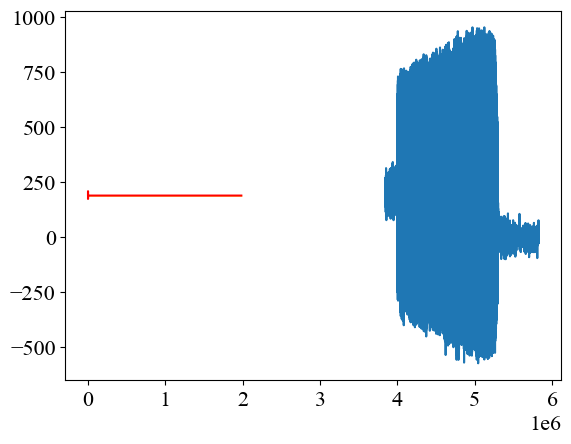

In [54]:
# Extract the confidence intervals from the forecast data
mean_forecast = np.mean(forecast_data)
std_forecast = np.std(forecast_data)

# Calculate the confidence interval endpoints
alpha = 0.05
z_score = norm.ppf(1 - alpha / 2)
conf_lower = mean_forecast - z_score * std_forecast
conf_upper = mean_forecast + z_score * std_forecast

# Compute the mean squared error
mse = mean_squared_error(test, forecast_data.values)
print('MSE: %.3f' % mse)

# Compute the mean absolute percentage error
mape = np.mean(np.abs((test - forecast_data.values) / test)) * 100
print('MAPE: %.3f' % mape)

# Plot the forecast with the confidence interval
plt.plot(test)
plt.plot(forecast_data.values, color='red')
plt.fill_between(x=range(0,len(test)), y1=conf_lower, y2=conf_upper, alpha=0.5, color='yellow')
plt.show()

### Time Series Anomaly Detection by Statistical Profiling Approach:

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the time series data
data_CH1_sensor = data_dict["V2_00001"]["dat"]["CH1_Moment"]

# Compute the mean and standard deviation of the data
mean = data_CH1_sensor.mean()
std = data_CH1_sensor.std()


# Define a threshold for anomaly detection
threshold = mean + 3 * std

# Compute the z-score of each data point
z_scores = stats.zscore(data_CH1_sensor)

# Identify the anomalous data points
anomalies = np.where(z_scores > threshold, 1, 0)

# Add the anomaly labels to the original data
data_CH1_sensor['anomaly'] = anomalies

anomalies

# # Plot the time series data with the predicted anomalies
# plt.plot(data_CH1_sensor.index, data_CH1_sensor, color='blue')
# plt.scatter(data_CH1_sensor[data_CH1_sensor['anomaly']==1].index, data_CH1_sensor[data_CH1_sensor['anomaly']==1], color='red')
# plt.show()

array([0, 0, 0, ..., 0, 0, 0])